In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/sabarishh14/FakeFind/main/twitter_data.csv'
data = pd.read_csv(url)


In [3]:
# Display the first few rows of the dataset
data.head()

,UserID,No Of Abuse Report,No Of Rejected Friend Requests,No Of Freind Requests Thar Are Not Accepted,No Of Friends,No Of Followers,No Of Likes To Unknown Account,No Of Comments Per Day,Fake Or Not Category
0,1,37,415,204,290,838,26,53,1
1,2,63,383,542,652,349,37,58,1
2,3,10,151,244,863,271,73,11,1
3,4,83,54,604,496,937,37,55,1
4,5,47,834,326,401,928,80,78,1


In [4]:
# Display the column names
data.columns


Index(['UserID', 'No Of Abuse Report', 'No Of Rejected Friend Requests',
       'No Of Freind Requests Thar Are Not Accepted', 'No Of Friends',
       'No Of Followers', 'No Of Likes To Unknown Account',
       'No Of Comments Per Day', 'Fake Or Not Category'],
      dtype='object')

In [5]:
# Rename columns for easier access
data.columns = ['UserID', 'AbuseReports', 'RejectedFriendRequests', 'UnacceptedFriendRequests',
                'FriendsCount', 'FollowersCount', 'LikesToUnknownAccounts', 'CommentsPerDay', 'FakeOrNot']

# Drop the 'UserID' column as it is not relevant for prediction
data = data.drop(columns=['UserID'])

# Check for missing values
data.isnull().sum()


AbuseReports                0
RejectedFriendRequests      0
UnacceptedFriendRequests    0
FriendsCount                0
FollowersCount              0
LikesToUnknownAccounts      0
CommentsPerDay              0
FakeOrNot                   0
dtype: int64

In [6]:
# Assuming no missing values, proceed to feature-target split
# Features (independent variables)
X = data.drop(columns=['FakeOrNot'])

# Target (dependent variable)
y = data['FakeOrNot']
# Check dataset balance
print("Class Distribution:\n", y.value_counts())


Class Distribution:
 FakeOrNot
1    835
0    165
Name: count, dtype: int64


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (800, 7), Testing Set: (200, 7)


In [8]:
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Balanced Training Set Shape: {X_train_resampled.shape}")
print("New Class Distribution:\n", pd.Series(y_train_resampled).value_counts())


Balanced Training Set Shape: (1336, 7)
New Class Distribution:
 FakeOrNot
1    668
0    668
Name: count, dtype: int64


In [9]:
# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [10]:
param_grid = {
    
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_resampled)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters Found:", best_params)


Best Parameters Found: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [11]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [12]:
y_pred = rf_classifier.predict(X_test)


In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 1.00


In [14]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and display the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 33   0]
 [  0 167]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00       167

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



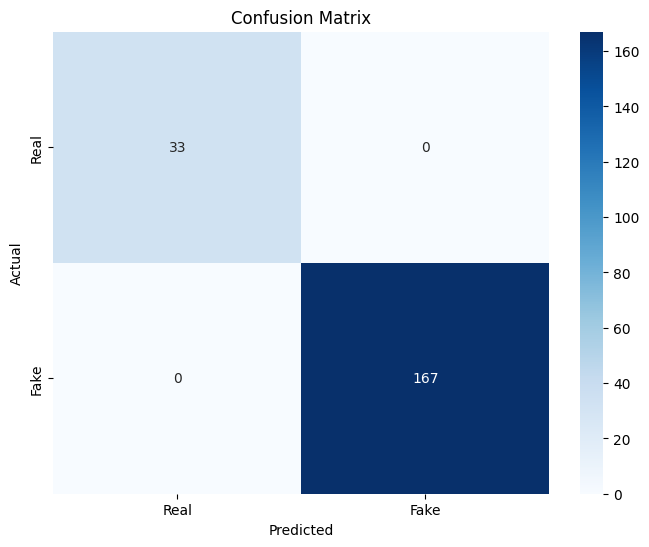

In [15]:

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Save the trained model and scaler
with open('rf_classifier.pkl', 'wb') as model_file:
    pickle.dump(rf_classifier, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("\nModel and Scaler Saved Successfully!")



Model and Scaler Saved Successfully!
